In [70]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()



urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")



total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])



total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)



total_data.drop_duplicates(subset=['reviews'], inplace=True)



# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)



# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)



# 중복 제거
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
# 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True) 
# Null 값 제거
test_data = test_data.dropna(how='any') 



from eunjeon import Mecab
mecab = Mecab()



stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']



train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])



X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values



# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 텍스트 데이터에 정수 인코딩 수행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)



# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



# 단어 집합 크기를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)



tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



# 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))



max_len = 80
below_threshold_len(max_len, X_train)



# 훈련용 리뷰의 99.99가 80이하의 길이를 가지기 때문에, 훈련용 리뷰를 길이 80으로 패딩

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)



# GRU로 네이버 쇼핑 리뷰 감성 분류

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))



def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    return 1
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    return 0



sentiment_predict("불친절")

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3858855300.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\3858855300.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495
단어 집합의 크기 : 21687
전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553
Epoch 1/15
1872/1875 [============================>.] - ETA: 0s - loss: 0.2724 - acc: 0.8961
Epoch 1: val_acc improved from -inf to 0.91466, saving model to best_model.h5
1875/1875 [==============================] - 35s 17ms/step - loss: 0.2724 - acc: 0.8961 - val_loss: 0.2353 - val_acc: 0.9147
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9223
Epoch 2: val_acc improved from 0.91466 to 0.92143, saving model to best_model.h5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2152 - acc: 0.9223 - val_loss: 0.2177 - val_acc: 0.9214
Epoch 3/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9289
Epoch 3: val_acc improved from 0.92143 to 0.92567, saving model to best_model.h5
1875/1875 [==============

0

In [71]:
data1 = pd.read_csv('goodnara.csv')
data2 = pd.read_csv('drstyle.csv')
data3 = pd.read_csv('thecheaper.csv')
data=pd.concat([data1, data2, data3], ignore_index=True)
data=data.loc[:, ['comment', 'date', 'star', 'topic']].dropna()

In [72]:
data

,comment,date,star,topic
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review
...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review


In [77]:
data['label'] = np.select([data.star > 3], ['긍정'], default='부정')

In [78]:
data['new_label']=None

In [ ]:
for i in range(len(data['comment'])):
    if sentiment_predict(data['comment'][i]) == 1:
        data['new_label'][i] = '긍정'
    else:
        data['new_label'][i] = '부정'

In [95]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [96]:
import collections
collections.Counter(data['label'])

Counter({'긍정': 17450, '부정': 2102})

In [97]:
collections.Counter(data['new_label'])

Counter({'긍정': 16277, '부정': 3275})

In [58]:
print('기존의 긍/부정 비율: '+str(round(collections.Counter(data['label'])[1]/(collections.Counter(data['label'])[1]+collections.Counter(data['label'])[-1]+collections.Counter(data['label'])[0])*100, 2))+'%')

기존의 긍/부정 비율: 89.25%


In [59]:
print('조정된 긍/부정 비율: '+str(round(collections.Counter(data['new_label'])[1]/(collections.Counter(data['new_label'])[1]+collections.Counter(data['new_label'])[-1]+collections.Counter(data['new_label'])[0])*100, 2))+'%')

조정된 긍/부정 비율: 82.29%


In [99]:
data.to_csv('jeonj.csv',encoding='utf-8-sig')

In [ ]:
from elasticsearch import Elasticsearch
def insertData():
    headers = {'Content-type': 'application/json'}
    es = Elasticsearch('http://43.200.44.17:9200', headers = headers)
    
    index="jeonj3"
    
    doc = {
        "date" : date

        #"@timestamp" : datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    }
    
    es.index(index="jeonj3", doc_type="_doc", body=doc)


In [ ]:
insertData()

In [118]:
data=a

In [119]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고\n편안하고 디자인도 깔끔해서\n재구매했습니다.\n좋은 ...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요. 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
19547,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
19548,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
19549,좋아요. 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
19550,아니 리뷰가 너무 좋습니다~~,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [106]:
data['comment'][0]

'평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑도 저도 한 머리크기 하는데 얼굴이 작아보이는 효과까지 있네요. ㅋㅋ 만족합니다.'

In [107]:
mecab.nouns()

['평소',
 '캡',
 '쇼',
 '주문',
 '배송',
 '모자',
 '신랑',
 '저',
 '머리',
 '크기',
 '데',
 '얼굴',
 '효과',
 '만족']

In [114]:
for i in data['comment']:
    i = mecab.nouns(i)

In [120]:
data=data.loc[:, ['comment', 'date', 'star', 'topic', 'label', 'new_label']].dropna()

# 중복 제거
data.drop_duplicates(subset = ['comment'], inplace=True, ignore_index=True) 
# 정규 표현식 수행
data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
data['comment'].replace('', np.nan, inplace=True) 
# Null 값 제거
data = data.dropna(how='any')

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

data=data.reset_index(drop=False)
data=data.loc[:, ['comment', 'date', 'star', 'topic', 'label', 'new_label']].dropna()

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\1340779050.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [121]:
data

,comment,date,star,topic,label,new_label
0,평소 볼캡을 안써서 흠뻑쇼에 쓰려고 급하게 주문했는데 배송 빠르고 모자가 커서 신랑...,2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,남편 워터파크 갈때 쓸 모자 샀어요 집에있는 모자가 프리사이즈이고 안에 설명되어있는...,2022-07-10,3,smartstore.goodnara.review,부정,부정
2,사이즈나 디자인은 너무 맘에 드는데 앞에서 보면 모자가 둥글지 않고 옆에 약간 뾰족...,2022-07-22,3,smartstore.goodnara.review,부정,부정
3,지난번 구입후 사용감도 좋고편안하고 디자인도 깔끔해서재구매했습니다좋은 제품 싸게사서...,2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,너무 좋아요 대두라서 모자 찾기 힘든데,2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
15139,조아요 예브네요ㅇㅇ,2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
15140,흰색 모자 쓰다가 잃어버려서 새로 샀는데 좋아요,2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
15141,좋아요 제품배송도 빠르고 저렴해서 맘에듭니다,2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
15142,아니 리뷰가 너무 좋습니다,2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [122]:
for i in range(len(data['comment'])):
    data['comment'][i] = mecab.nouns(data['comment'][i])

C:\Users\jeonj\AppData\Local\Temp\ipykernel_3636\684740107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comment'][i] = mecab.nouns(data['comment'][i])


In [125]:
data['comment'][0]

['평소',
 '캡',
 '쇼',
 '주문',
 '배송',
 '모자',
 '신랑',
 '저',
 '머리',
 '크기',
 '데',
 '얼굴',
 '효과',
 '만족']

In [126]:
data

,comment,date,star,topic,label,new_label
0,"[평소, 캡, 쇼, 주문, 배송, 모자, 신랑, 저, 머리, 크기, 데, 얼굴, 효...",2022-07-26,5,smartstore.goodnara.review,긍정,긍정
1,"[남편, 워터, 파크, 때, 모자, 집, 모자, 프리, 사이즈, 안, 설명, 사이즈...",2022-07-10,3,smartstore.goodnara.review,부정,부정
2,"[사이즈, 디자인, 맘, 앞, 모자, 옆, 모양]",2022-07-22,3,smartstore.goodnara.review,부정,부정
3,"[지난번, 구입, 후, 사용, 편안, 디자인, 구매, 제품, 서비스, 번창]",2022-07-19,5,smartstore.goodnara.review,긍정,긍정
4,"[대두, 모자]",2022-07-10,5,smartstore.goodnara.review,긍정,긍정
...,...,...,...,...,...,...
15139,[조아],2019-04-07,5,smartstore.thecheaper.review,긍정,긍정
15140,"[흰색, 모자]",2019-03-28,5,smartstore.thecheaper.review,긍정,긍정
15141,"[제품, 배송, 맘]",2019-03-18,4,smartstore.thecheaper.review,긍정,긍정
15142,[리뷰],2019-04-02,5,smartstore.thecheaper.review,긍정,긍정


In [141]:
from elasticsearch import Elasticsearch
def insertData(comment, date, star, topic, label, new_label):
    headers = {'Content-type': 'application/json'}
    es = Elasticsearch('http://43.200.44.17:9200', headers = headers)
    
    index="analyzed_data"
    
    doc = {
        "Name": topic,
        "Star": star,
        "Date": date,
        "Word": comment,
        "Sentiment": label,
        "Adjustment-sentiment": new_label

        #"@timestamp" : datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    }
    
    es.index(index="analyzed_data", doc_type="_doc", body=doc)


In [148]:
for i in range(len(data)):
    insertData(data['comment'][i], data['date'][i], data['star'][i], data['topic'][i], data['label'][i], data['new_label'][i])

In [143]:
len(data)

15144

In [144]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2168700   
                                                                 
 gru_2 (GRU)                 (None, 128)               88320     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,257,149
Trainable params: 2,257,149
Non-trainable params: 0
_________________________________________________________________


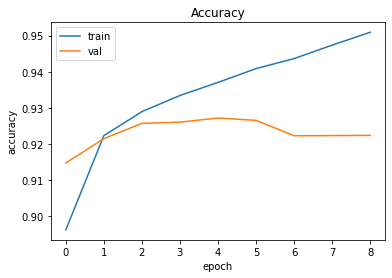

In [145]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

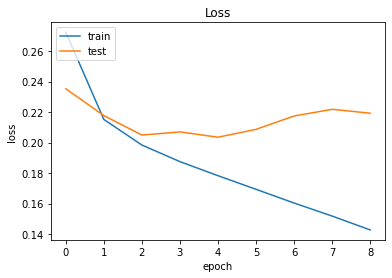

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()